In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = './recordingSpecAugmentSigmoid'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['backgroundNoise', '他', '你', '好', '我', '的', '贅詞']


In [4]:
# Settings
feature_sets_path = './npz/'
feature_sets_filename = 'recordingSpecAugmentSigmoid.npz'
model_filename = './h5/recordingSpecAugmentSigmoid.h5'
wake_word = '贅詞'

In [5]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6828, 13, 49)
(2276, 13, 49)
(2276, 13, 49)


In [8]:
# Peek at labels
print(y_val)

[2. 6. 6. ... 6. 6. 6.]


In [9]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Peek at labels after conversion
total = 0
print(y_val)
for i in y_val:
    if i == 1:
        total = total + 1
print(total / len(y_val))

[0. 1. 1. ... 1. 1. 1.]
0.6832161687170475


In [11]:
# What percentage of 'stop' appear in validation labels
print(sum(y_train) / len(y_train))
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.6736965436438196
0.6832161687170475
0.3167838312829525


In [12]:
# View the dimensions of our input data
print(x_train.shape)

(6828, 13, 49)


In [13]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6828, 13, 49, 1)
(2276, 13, 49, 1)
(2276, 13, 49, 1)


In [14]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(13, 49, 1)


In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu',input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(1, 1)))
model.add(layers.Dropout(0.2))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
# Display model
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 12, 48, 32)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 24, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 23, 64)         8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 11, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 10, 128)        32896     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 10, 128)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 10, 128)       

In [25]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [26]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=25, 
                    batch_size=50, 
                    validation_data=(x_val, y_val))

Epoch 1/25
137/137 [==============================] - 3s 14ms/step - loss: 0.6964 - acc: 0.7273 - val_loss: 0.4568 - val_acc: 0.8049
Epoch 2/25
137/137 [==============================] - 2s 13ms/step - loss: 0.4371 - acc: 0.8026 - val_loss: 0.4034 - val_acc: 0.8212
Epoch 3/25
137/137 [==============================] - 2s 13ms/step - loss: 0.3593 - acc: 0.8437 - val_loss: 0.3490 - val_acc: 0.8550
Epoch 4/25
137/137 [==============================] - 2s 13ms/step - loss: 0.3277 - acc: 0.8593 - val_loss: 0.3455 - val_acc: 0.8594
Epoch 5/25
137/137 [==============================] - 2s 13ms/step - loss: 0.2863 - acc: 0.8789 - val_loss: 0.3596 - val_acc: 0.8656
Epoch 6/25
137/137 [==============================] - 2s 13ms/step - loss: 0.2688 - acc: 0.8856 - val_loss: 0.2934 - val_acc: 0.8831
Epoch 7/25
137/137 [==============================] - 2s 13ms/step - loss: 0.2482 - acc: 0.8973 - val_loss: 0.3162 - val_acc: 0.8792
Epoch 8/25
137/137 [==============================] - 2s 13ms/step - 

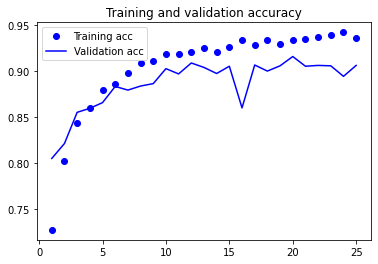

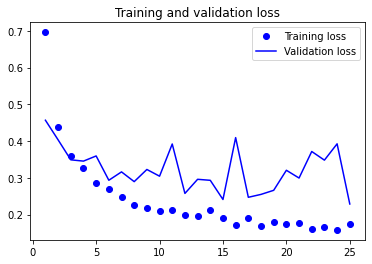

In [27]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
# Save the model as a file
models.save_model(model, model_filename)

In [29]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

0
1
3
4
6
7
8
9
12
13
15
17
18
19
20
21
22
23
24
26
28
29
30
31
33
34
36
37
39
40
42
44
46
47
48
50
51
54
55
56
57
58
60
61
62
63
64
66
67
69
70
71
73
76
78
83
85
86
87
89
91
93
94
97
98
99
100
101
102
104
106
107
108
109
110
111
113
114
117
118
121
123
124
125
126
127
129
130
132
133
134
135
136
137
138
139
140
141
142
143
145
146
147
148
149
150
151
152
153
155
156
157
158
160
161
162
163
164
165
166
168
169
170
172
173
178
179
181
182
184
186
188
189
190
191
192
193
195
196
198
201
202
205
206
207
208
211
212
215
216
217
218
219
220
221
222
225
227
228
230
232
233
235
236
239
241
242
243
245
247
248
249
250
251
253
254
255
256
257
258
261
262
264
265
266
268
270
273
274
276
277
279
281
282
286
289
290
292
294
295
298
299
301
302
304
305
308
310
311
312
313
314
315
317
322
323
326
327
328
329
330
332
333
334
335
336
338
341
342
346
348
349
350
351
352
353
354
357
358
359
360
362
365
366
367
368
371
374
375
377
380
381
382
384
385
386
387
389
390
391
394
395
396
397
398
399
400
401
40

In [30]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(0, 50):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[0.7568583]]
Answer: 1.0  Prediction: [[0.6094171]]
Answer: 0.0  Prediction: [[0.00100357]]
Answer: 1.0  Prediction: [[0.9999989]]
Answer: 1.0  Prediction: [[0.58515316]]
Answer: 0.0  Prediction: [[0.19077045]]
Answer: 1.0  Prediction: [[0.99999964]]
Answer: 1.0  Prediction: [[0.9975871]]
Answer: 1.0  Prediction: [[0.9980515]]
Answer: 1.0  Prediction: [[0.8953776]]
Answer: 0.0  Prediction: [[0.29285195]]
Answer: 0.0  Prediction: [[0.5024545]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[0.97592497]]
Answer: 0.0  Prediction: [[0.03917544]]
Answer: 1.0  Prediction: [[0.82602537]]
Answer: 0.0  Prediction: [[0.72391164]]
Answer: 1.0  Prediction: [[0.9120234]]
Answer: 1.0  Prediction: [[0.9995938]]
Answer: 1.0  Prediction: [[0.72254205]]
Answer: 1.0  Prediction: [[0.9996737]]
Answer: 1.0  Prediction: [[0.65439117]]
Answer: 1.0  Prediction: [[0.8690412]]
Answer: 1.0  Prediction: [[0.9997538]]
Answer: 1.0  Prediction: [[0.992778]]
Answer: 0.0  Predictio

In [31]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

72/72 [==============================] - 1s 5ms/step - loss: 0.2262 - acc: 0.9121


[0.22622781991958618, 0.9121265411376953]